In [98]:
# Polynomial Linear Regression of ten features for price prediction
# Train RMSE:  23909.74669873437
# Train R2:  0.913992426286501
# Test RMSE:  30094.857644477812
# Test R2:  0.8165772814111537

In [99]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')

tf = pd.read_csv('test.csv')

tf['Functional']
# count = tf['Functional'].isnull().sum()
count = tf['Functional'].value_counts()
print(count)

Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: Functional, dtype: int64


In [100]:
from sklearn import preprocessing
from sklearn.preprocessing import scale

def add_features_o(df):
    df['TotalSF'] = df['1stFlrSF']+df['2ndFlrSF']+df['TotalBsmtSF']
    # df['OverallQCP'] = (df['OverallQual']+df['OverallCond'])/20
    df['OverallQCP'] = (df['OverallQual']*df['OverallCond'])/100
    df['TotalBath'] = df['FullBath']+df['BsmtFullBath']

    df_new = df

    #create two quant features for location (relevant to price)...median is better
    hood_names = df_new['Neighborhood'].unique()
    hood_avg_prices = []
    hood_median_prices = []
    for name in hood_names:
        df_temp = df_new[(df_new['Neighborhood']==name)]
        avg_price = int(df_temp['SalePrice'].mean())
        hood_avg_prices.append(avg_price)
        median_price = df_temp['SalePrice'].median()
        hood_median_prices.append(median_price)
    #     print("{} has an average home sale price of {}".format(name,avg_price))

    name_avg_price_dict = dict(zip(hood_names, hood_avg_prices))
    df_new['HoodAvg'] = df_new['Neighborhood'].map(lambda x: name_avg_price_dict[x])
    name_med_price_dict = dict(zip(hood_names, hood_median_prices))
    df_new['HoodMed'] = df_new['Neighborhood'].map(lambda x: name_med_price_dict[x])

    #create quant feature for Functional
    func_dict ={
        'Typ':7,
        'Min1':6,
        'Min2':5,
        'Mod':4,
        'Maj1':3,
        'Maj2':2,
        'Sev':1,
        'Sal':0  
    }
    df_new['FuncScore'] = df_new['Functional'].map(lambda x: func_dict[x])
    
    return df_new, name_avg_price_dict, name_med_price_dict

def add_features_m(df, name_avg_price_dict, name_med_price_dict):
    df['TotalSF'] = df['1stFlrSF']+df['2ndFlrSF']+df['TotalBsmtSF']
    # df['OverallQCP'] = (df['OverallQual']+df['OverallCond'])/20
    df['OverallQCP'] = (df['OverallQual']*df['OverallCond'])/100
    df['TotalBath'] = df['FullBath']+df['BsmtFullBath']

    df_new = df

    df_new['HoodAvg'] = df_new['Neighborhood'].map(lambda x: name_avg_price_dict[x])
    df_new['HoodMed'] = df_new['Neighborhood'].map(lambda x: name_med_price_dict[x])

    #create quant feature for Functional
    func_dict ={
        'Typ':7,
        'Min1':6,
        'Min2':5,
        'Mod':4,
        'Maj1':3,
        'Maj2':2,
        'Sev':1,
        'Sal':0  
    }
    df_new['FuncScore'] = df_new['Functional'].map(lambda x: func_dict[x] if not pd.isnull(x) else 7)
    
    return df_new

df_new, name_avg_price_dict, name_med_price_dict = add_features_o(df)
tf_new = add_features_m(tf, name_avg_price_dict, name_med_price_dict)

#tf_new['FuncScore']

In [101]:
#feature exploration

import matplotlib.pyplot as plt

# count = df_new['YrSold'].isnull().sum()
# print(count)

def plot_histogram(x):
    plt.hist(x,color='gray', alpha=0.5)
    plt.title("Hist of {var_name}".format(var_name=x.name))
    plt.show
    
def plot_scatter(X, y):
    plt.scatter(X, y, alpha=0.5)
    plt.title("Scatter Plot of {} vs. {}".format(X.name, y.name))
    plt.show
    

/var/folders/j9/ysjy31n16hzdqp8hpdl_lj4w0000gn/T/ipykernel_31476/271664103.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt[col] = Xt[col].map(lambda x: x if not pd.isnull(x) else Xt[col].median())


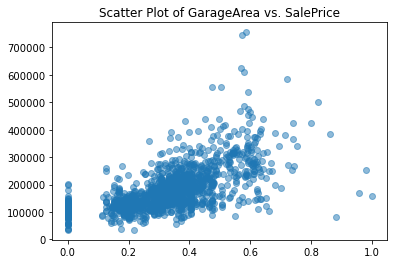

In [102]:
#standardize features of interest
cols = ['HoodAvg','HoodMed','TotalSF','OverallQCP','FuncScore','TotalBath','TotRmsAbvGrd','BedroomAbvGr','LotArea','GarageArea']
colst = ['Id','HoodAvg','HoodMed','TotalSF','OverallQCP','FuncScore','TotalBath','TotRmsAbvGrd','BedroomAbvGr','LotArea','GarageArea']


def standardize_foi(cols, df_new):
    scaler = preprocessing.MinMaxScaler()
    for feature in cols:
        feature_mat = df_new[feature].values.reshape(-1,1)
        df_new[feature] = scaler.fit_transform(feature_mat)
    return df_new

df_new = standardize_foi(cols, df_new)
X = df_new[cols]
y = df_new['SalePrice']

tf_new = standardize_foi(cols, tf_new)
Xt = tf_new[cols]

for col in cols:
    Xt[col] = Xt[col].map(lambda x: x if not pd.isnull(x) else Xt[col].median())


#feature exploration
plot_scatter(df_new["GarageArea"], df_new["SalePrice"])

In [103]:
# remove and replace oulier data with the median for...
# HoodMed
# TotalSF
# OverallQCP
# TotalBath
# TotRmsAbvGrd
# LotArea
# GarageArea


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# cols = ['HoodAvg','HoodMed','TotalSF','OverallQCP','FuncScore','TotalBath','TotRmsAbvGrd','BedroomAbvGr','LotArea','GarageArea']
# count = Xt['TotalSF'].isnull().sum()
# print(count)

def find_model_perf(X_train, y_train, X_test, y_test, Xt):
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X_train) #
    model = LinearRegression()
    model.fit(X_poly, y_train) #
    
    Xt_test_poly = poly.transform(Xt)
    yt_test_results = model.predict(Xt_test_poly)
    toprint = pd.DataFrame()
    toprint['Id'] = tf_new.Id.values
    toprint['SalePrice'] = yt_test_results
    toprint.to_csv('drchachere-predictions.csv', index=False)
    
#     y_results = model.predict(X_poly) #
#     rmse = np.sqrt(mean_squared_error(y_train,y_results))
#     r2 = r2_score(y_train,y_results)
#     print('Train RMSE: ', rmse)
#     print('Train R2: ', r2)
    
#     X_test_poly = poly.transform(X_test)
#     y_test_results = model.predict(X_test_poly)
#     rmse = np.sqrt(mean_squared_error(y_test,y_test_results))
#     r2 = r2_score(y_test,y_test_results)
#     print('Test RMSE: ', rmse)
#     print('Test R2: ', r2)
    return

find_model_perf(X_train, y_train, X_test, y_test, Xt)